In [1]:
#Basics
import re
import os, sys
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
import json

#Imaging
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import plotly.express as px

#Torch
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Dataset script for Dataloader
from glyph_dataset import *

## Deep Learning applied to Ancient Egyptian Hieroglyphs

### Preparing Data

The Glyph Dataset is built from the hieroglyphs found in 10 different pictures from the book "The Pyramid of Unas" (Alexandre Piankoff, 1955)

They have been preprocessed to have the size 75x50, and their label is included in the image name:

For example: **030001_D58**.png is a hieroglyph from picture 3 (**03**) out of Piankoff's book, and it is the second hieroglyph (**0001**, w. indexing starting at 0000)

The label is then **D58**

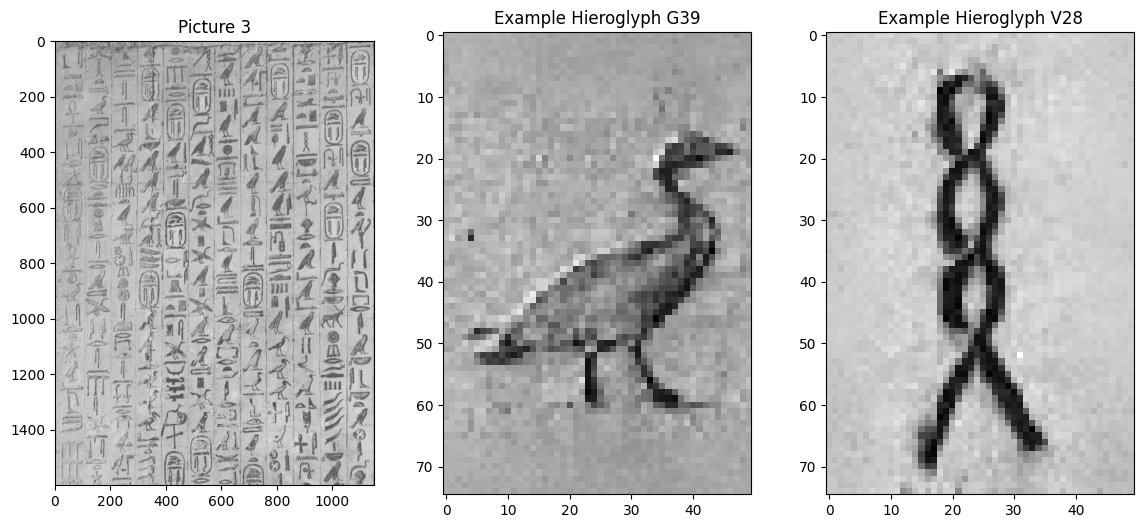

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(14,6))

# Plot full
axes[0].imshow(mpimg.imread(r"GlyphDataset\Dataset\Pictures\egyptianTexts3.jpg"))
axes[0].set_title('Picture 3')

# Plot glyph
axes[1].imshow(mpimg.imread(r"GlyphDataset\Dataset\Automated\Preprocessed\3\030010_G39.png"), cmap='grey')
axes[1].set_title('Example Hieroglyph G39')

# Plot glyph
im = axes[2].imshow(mpimg.imread(r"GlyphDataset\Dataset\Automated\Preprocessed\3\030370_V28.png"), cmap='grey')
axes[2].set_title('Example Hieroglyph V28')

plt.show()

Let's copy the files into a folder "Train"

In [3]:
source_dir = 'GlyphDataset/Dataset/Manual/Preprocessed'
target_dir = 'GlyphDataset/Train'

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Function to copy all files from source to target directory
def copy_files(source, target):
    for item in tqdm(os.listdir(source)):
        s = os.path.join(source, item)
        d = os.path.join(target, item)
        if os.path.isdir(s):
            os.makedirs(d, exist_ok=True)  # Create directory if not exists
            copy_files(s, d)  # Recursively copy subdirectory
        else:
            shutil.copy2(s, d)  # Copy files and preserve metadata

# Copy all files and subdirectories
copy_files(source_dir, target_dir)
print("Folder contents copied successfully!")

100%|██████████| 10/10 [01:36<00:00,  9.65s/it]

Folder contents copied successfully!


All of the pngs are in subfolders named according to the image they come from. We get rid of those subfolders and collect all the images in the train folder.

In [4]:
train_dir = 'GlyphDataset/Train'

# Step 1: Move all .png files to the train_dir
for root, dirs, files in os.walk(train_dir, topdown=False):  # topdown=False is important for later deletion
    for file in files:
        if file.endswith('.png'):
            # Construct the full file path
            file_path = os.path.join(root, file)
            # Construct the target file path
            target_path = os.path.join(train_dir, file)
            
            # Move the file
            shutil.move(file_path, target_path)

# Step 2: Remove all empty directories
for root, dirs, files in os.walk(train_dir, topdown=False):
    for dir in dirs:
        dir_path = os.path.join(root, dir)
        # Check if the directory is empty
        if not os.listdir(dir_path):
            try:
                os.rmdir(dir_path)
                print(f"Removed empty directory: {dir_path}")
            except Exception as e:
                print(f"Failed to remove {dir_path}: {e}")

Removed empty directory: GlyphDataset/Train\20
Removed empty directory: GlyphDataset/Train\21
Removed empty directory: GlyphDataset/Train\22
Removed empty directory: GlyphDataset/Train\23
Removed empty directory: GlyphDataset/Train\3
Removed empty directory: GlyphDataset/Train\39
Removed empty directory: GlyphDataset/Train\41
Removed empty directory: GlyphDataset/Train\5
Removed empty directory: GlyphDataset/Train\7
Removed empty directory: GlyphDataset/Train\9


The labels are in the filenames and need to be encoded for the model to handle them. We define the mapping from labels to integers and save it as a .json file.

In [5]:
def create_label_encoding_file(dataset_path, file_path='label_encoding.json'):
    filenames = os.listdir(dataset_path)
    labels = [filename[filename.rfind('_')+1:filename.rfind('.')] for filename in filenames]
    unique_labels = sorted(set(labels))
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    
    with open(file_path, 'w') as f:
        json.dump(label_to_int, f)

def load_label_mappings(file_path):
    with open(file_path, 'r') as f:
        label_to_int = json.load(f)
    int_to_label = {v: k for k, v in label_to_int.items()}
    return label_to_int, int_to_label

In [6]:
create_label_encoding_file(train_dir)

DataLoader Parameters

In [7]:
BATCH_SIZE = 100
NUM_WORKERS = 5
SHUFFLE = False

In [8]:
# Define transformations work in progress
# class transform(object):
#     def normalize_img(self, img, mean=['?'], std=['?']):
#         return '?'

transform = transforms.Compose([
    transforms.ToTensor()
])

In [9]:
train_ds = Glyph_Dataset(dataset_path="GlyphDataset/Train",
                         label_encoder_file= 'label_encoding.json',
                         augmentation=transform,
                         preprocessing=None)

train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

In [10]:
images, labels = next(iter(train_loader))

In [11]:
images.shape

torch.Size([100, 1, 75, 50])

In [12]:
labels.shape

torch.Size([100])

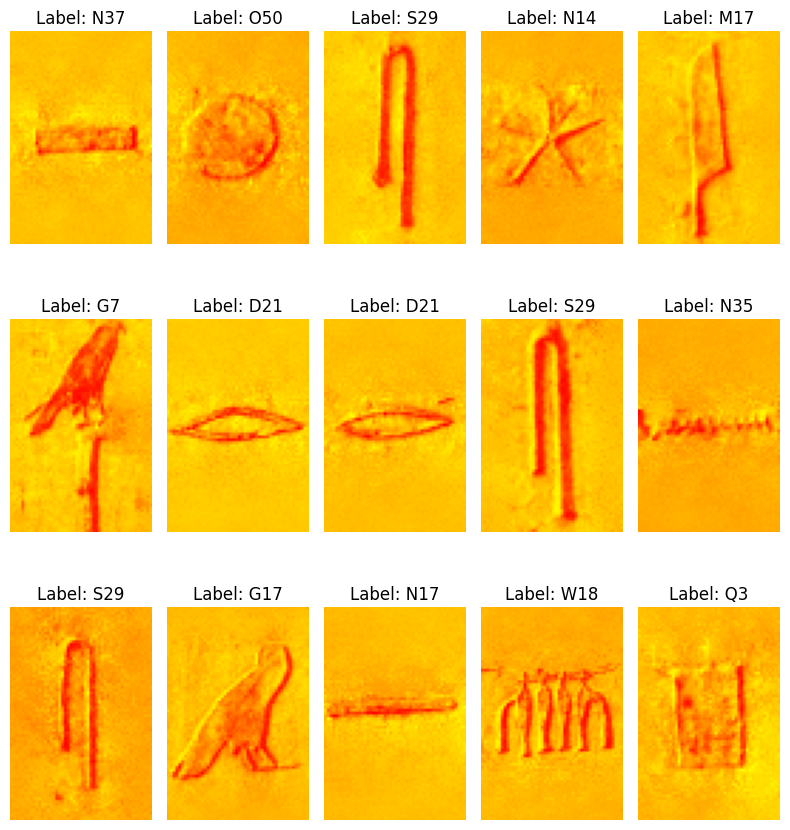

In [13]:
fig, axis = plt.subplots(3, 5, figsize=(8, 9))

for ax in axis.flat:
    _, int_to_label = load_label_mappings('label_encoding.json')
    i = np.random.randint(len(labels))
    decoded_label = int_to_label[float(labels[i])]

    ax.imshow(images[i,0,:,:], cmap='autumn')
    ax.set(title = f"Label: {decoded_label}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [14]:
labels = []
for filename in os.listdir("GlyphDataset/Train"):
    last_underscore_index = filename.rfind('_')
    label = filename[last_underscore_index+1:filename.rfind('.')]
    labels.append(label)

codes, counts = np.unique(labels, return_counts=True)

In [15]:
codes, counts = np.unique(labels, return_counts=True)

sorted_indices = np.argsort(counts)
sorted_codes = codes[sorted_indices]
sorted_counts = counts[sorted_indices]

exclusion_count = 120  # Excluding a bunch of the lowest out of the plot
filtered_codes = sorted_codes[exclusion_count:]
filtered_counts = sorted_counts[exclusion_count:]

# Create the bar chart with filtered data
fig = px.bar(
    x=filtered_counts, 
    y=filtered_codes,
    orientation='h',
    labels={'x': 'Count', 'y': 'Codes'},
    title='Horizontal Bar Chart of Codes'
)

# Update layout and show the plot
fig.update_layout(
    autosize=False,
    width=1000,
    height=1200
)
fig.show()

### Stratified Test and Validation Datasets

There are some codes with very few occurences, which makes it impossible to stratify the Train-Val-Test split. As a preliminary approach I will exclude them from the stratification and add them back to Train afterwards.

In [16]:
train_dir = 'GlyphDataset/Train'
filepaths = [os.path.join(train_dir, filename) for filename in sorted(os.listdir(train_dir))]

In [17]:
import collections

class_count = collections.Counter(labels)

# Threshold for minimum samples for class to be included in stratification
min_samples_per_class = 8

train_files_direct = [f for f, l in zip(filepaths, labels) if class_count[l] < min_samples_per_class]
train_labels_direct = [l for f, l in zip(filepaths, labels) if class_count[l] < min_samples_per_class]
stratify_files = [f for f, l in zip(filepaths, labels) if class_count[l] >= min_samples_per_class]
stratify_labels = [l for f, l in zip(filepaths, labels) if class_count[l] >= min_samples_per_class]


In [18]:
from sklearn.model_selection import train_test_split

# We split Train into two, then the smaller part again for 3 splits
train_files, test_val_files, train_labels, test_val_labels = train_test_split(
    stratify_files, stratify_labels, test_size=0.4, random_state=23, stratify=stratify_labels)

# Further split test_val into validation and test sets
val_files, test_files, val_labels, test_labels = train_test_split(
    test_val_files, test_val_labels, test_size=0.6, random_state=23, stratify=test_val_labels)


In [20]:
def copy_files(file_list, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    for file in file_list:
        shutil.move(file, dest_folder)

parent_dir = "GlyphDataset/"

copy_files(val_files, os.path.join(parent_dir, 'Validation'))
copy_files(test_files, os.path.join(parent_dir, 'Test'))

In [21]:
print(len(os.listdir('GlyphDataset/Train')))
print(len(os.listdir('GlyphDataset/Validation')))
print(len(os.listdir('GlyphDataset/Test')))

2639
628
943


### Model

In [47]:
# PARAMS
BATCH_SIZE = 60
NUM_WORKERS = 8
PIN_MEMORY = False
SHUFFLE = False # True is supposed to generalise better
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
PATIENCE = 4
# NUM_BATCHES = 10 this one when want to break early, train just one batch etc.
LOAD_MODEL = False
DEVICE = 'cpu'

In [48]:
# Setup Train Loader
train_ds = Glyph_Dataset(dataset_path="GlyphDataset/Train",
                         label_encoder_file='label_encoding.json',
                         augmentation=transform, 
                         preprocessing=None)

train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

# Setup Valid Loader
val_ds = Glyph_Dataset(dataset_path="GlyphDataset/Validation",
                         label_encoder_file='label_encoding.json', 
                         augmentation=transform, 
                         preprocessing=None)

val_loader = DataLoader(val_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

# Setup Test Loader
test_ds = Glyph_Dataset(dataset_path="GlyphDataset/Test",
                         label_encoder_file='label_encoding.json', 
                         augmentation=transform, 
                         preprocessing=None)

test_loader = DataLoader(test_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

In [49]:
images, labels = next(iter(test_loader))

In [50]:
print(images.shape) # batch_sizex70x50

print(labels.shape) # batch_size

torch.Size([60, 1, 75, 50])
torch.Size([60])


In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes=172):
        super(Net, self).__init__()
        
        # Initial Convolution and MaxPooling layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Sequence of Separable Convolutions
        self.sepconv1 = self._make_layer(64, 128)
        self.sepconv2 = self._make_layer(128, 128)
        self.sepconv3 = self._make_layer(128, 256)
        self.sepconv4 = self._make_layer(256, 256)
        self.sepconv5 = self._make_layer(256, 512)

        # Global Average Pooling and Fully Connected Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.15)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels):
        layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, groups=in_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            self.pool
        )
        return layer

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.sepconv1(x)
        x = self.sepconv2(x)
        x = self.sepconv3(x)
        x = self.sepconv4(x)
        x = self.sepconv5(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [94]:
model = Net(num_classes=10)
print(model)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (sepconv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (sepconv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil

In [95]:
def train_fn(loader, model, optimizer, loss_fn, device):
    loop = tqdm(loader)
    model.train()  # Set the model to training mode
    loss_sum = 0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device, dtype=torch.long)  # Ensure targets are long

        # Forward pass
        if device == 'cpu':
            with torch.cpu.amp.autocast():
                predictions = model(data)
                loss = loss_fn(predictions, targets)
        elif device == 'cuda':
            with torch.cuda.amp.autocast():
                predictions = model(data)
                loss = loss_fn(predictions, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update tqdm loop
        loop.set_postfix(loss=loss.item())
        loss_sum += loss.item()

    return loss_sum / len(loader)  # Return average loss

def validate_fn(loader, model, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device, dtype=torch.long)  # Ensure targets are long
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            val_loss += loss.item()
            
    return val_loss / len(loader)  # Return average validation loss

In [96]:
def save_predictions_and_labels(loader, model, device):
    pred_list = []
    label_list = []
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for x, labels in loader:
            x = x.to(device)
            labels = labels.to(device)
            
            preds = F.softmax(model(x), dim=1)

            # Move preds and labels back to CPU and convert to numpy
            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()
            
            pred_list.extend(preds)
            label_list.extend(labels)

    model.train()  # Set model back to training mode
    return pred_list, label_list



def save_checkpoint(state, filename="checkpoint_cnn.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [97]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def main():

    model = Net().to(DEVICE)

    loss_fn = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Create the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-7)

    train_losses = []
    val_losses = []
    lowest_val_loss = np.inf
    epochs_no_improvement = 0
    epochs_completed = 0

    if LOAD_MODEL:
        load_checkpoint(torch.load("checkpoint_cnn.pth.tar"), model)

    for epoch in range(NUM_EPOCHS):
        
        epochs_completed += 1
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

        # Log the current learning rate
        current_lr = get_lr(optimizer)
        print(f"Current learning rate: {current_lr}")

        loss = train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
        val_loss = validate_fn(val_loader, model, loss_fn, DEVICE)
        print(f'Avg. Validation loss: {val_loss} Avg. Training loss: {loss}' )

        if val_loss < lowest_val_loss:
            epochs_no_improvement = 0
            lowest_val_loss = val_loss
        else:
            epochs_no_improvement += 1

        if epochs_no_improvement == PATIENCE:
            print("Early Stopping")
            epochs_completed -= 1
            break

        train_losses.append(loss)
        val_losses.append(val_loss)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

    # Plot the training loss
    plt.figure()
    plt.plot(range(1, epochs_completed + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs_completed + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    pred_list, label_list = save_predictions_and_labels(loader=test_loader, model=model, device=DEVICE)

    return model, pred_list, label_list

Epoch 1/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:29<00:00,  3.40s/it, loss=2.47]


Avg. Validation loss: 3.2699688347903164 Avg. Training loss: 2.9167123193090614
=> Saving checkpoint
Epoch 2/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:33<00:00,  3.50s/it, loss=1.47] 


Avg. Validation loss: 1.127396290952509 Avg. Training loss: 1.5508567609570243
=> Saving checkpoint
Epoch 3/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:24<00:00,  3.29s/it, loss=1.05] 


Avg. Validation loss: 0.9245189292864366 Avg. Training loss: 1.0025534507903187
=> Saving checkpoint
Epoch 4/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:25<00:00,  3.30s/it, loss=0.655]


Avg. Validation loss: 0.7974367846142162 Avg. Training loss: 0.6520471376451579
=> Saving checkpoint
Epoch 5/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:24<00:00,  3.30s/it, loss=0.476]


Avg. Validation loss: 0.8868018334562128 Avg. Training loss: 0.40831138362938707
=> Saving checkpoint
Epoch 6/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:44<00:00,  3.73s/it, loss=0.237] 


Avg. Validation loss: 0.7913710176944733 Avg. Training loss: 0.2504813740537925
=> Saving checkpoint
Epoch 7/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:41<00:00,  3.68s/it, loss=0.2]   


Avg. Validation loss: 0.7874697189439427 Avg. Training loss: 0.16029619789597663
=> Saving checkpoint
Epoch 8/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:45<00:00,  3.76s/it, loss=0.0756]


Avg. Validation loss: 0.5939328142187812 Avg. Training loss: 0.0938165665350177
=> Saving checkpoint
Epoch 9/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:45<00:00,  3.76s/it, loss=0.0651]


Avg. Validation loss: 0.6432323916391893 Avg. Training loss: 0.07936905015429313
=> Saving checkpoint
Epoch 10/10
Current learning rate: 0.001


100%|██████████| 44/44 [02:40<00:00,  3.66s/it, loss=0.0282]


Avg. Validation loss: 0.5595717254010114 Avg. Training loss: 0.06030105181377043
=> Saving checkpoint


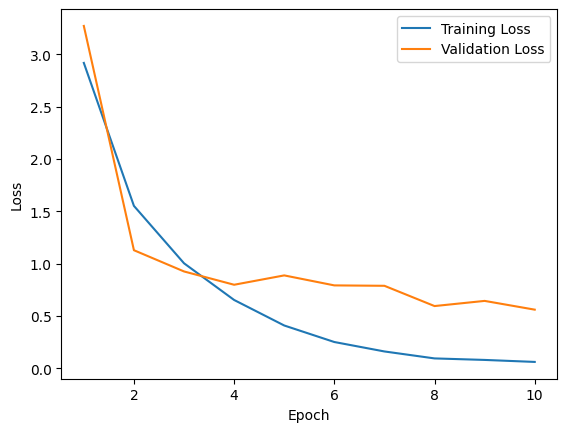

In [98]:
if __name__ == "__main__":
    model, pred_list, label_list = main()

In [99]:
import numpy as np
import plotly.graph_objects as go

# Convert predictions to predicted class indices
predicted_classes = [np.argmax(pred) for pred in pred_list]  # Assuming pred_list is your list of prediction arrays
true_labels = [label for label in label_list]  # Assuming label_list is your list of true labels

# Load mappings
_, int_to_label = load_label_mappings('label_encoding.json')

# Convert class indices back to label codes
predicted_codes = [int_to_label[pred] for pred in predicted_classes]
true_codes = [int_to_label[label] for label in true_labels]

# Get all unique labels present in both true and predicted data
all_labels = np.union1d(np.unique(true_codes), np.unique(predicted_codes))

# Count occurrences of each label in both actual and predicted
counts_true = np.zeros(len(all_labels), dtype=int)
counts_pred = np.zeros(len(all_labels), dtype=int)

for i, label in enumerate(all_labels):
    counts_true[i] = np.sum(np.array(true_codes) == label)
    counts_pred[i] = np.sum(np.array(predicted_codes) == label)

# Create traces for the actual and predicted data
trace1 = go.Bar(
    y=all_labels, 
    x=counts_true, 
    name='Actual Labels', 
    orientation='h'
)

trace2 = go.Bar(
    y=all_labels, 
    x=counts_pred, 
    name='Predicted Labels', 
    orientation='h'
)

# Create the figure
fig = go.Figure(data=[trace1, trace2])

# Update layout
fig.update_layout(
    title='Actual vs Predicted Label Distribution',
    barmode='group',
    bargap=0.15,  # controls the gap between bars of different sets
    bargroupgap=0.1,  # controls the gap between bars of the same set
    autosize=False,
    width=1000,
    height=1200,
    yaxis=dict(
        title='Class Labels'
    ),
    xaxis=dict(
        title='Frequency'
    )
)

# Show the plot
fig.show()

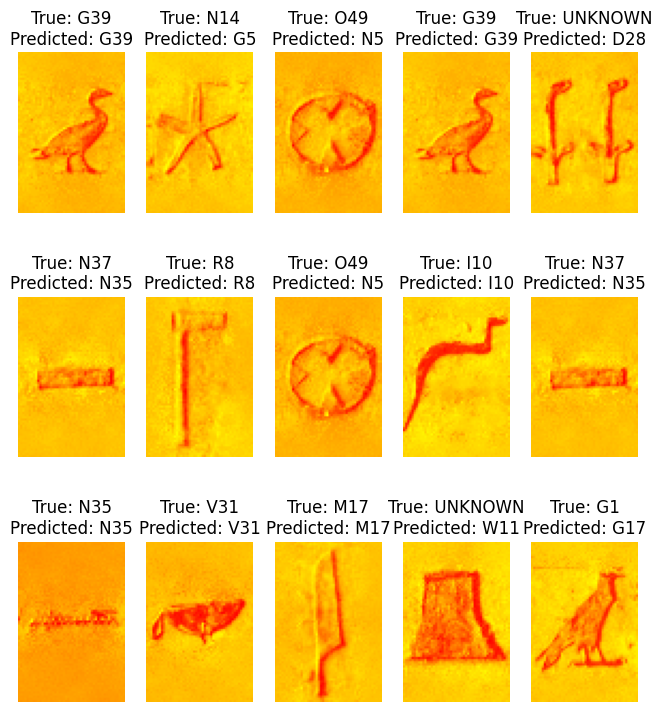

In [106]:
fig, axis = plt.subplots(3, 5, figsize=(8, 9))

for ax in axis.flat:
    i = np.random.randint(len(labels))
    ax.imshow(test_ds[i][0][0,:,:], cmap='autumn')

    assert int_to_label[test_ds[i][1]] ==  true_codes[i]
    
    ax.set(title=f'True: {int_to_label[test_ds[i][1]]}\nPredicted: {predicted_codes[i]}')
    ax.set_axis_off()
plt.show()

In [105]:
from sklearn.metrics import classification_report

print(classification_report(y_true=true_codes, y_pred=predicted_codes, zero_division=0))

              precision    recall  f1-score   support

          D2       0.86      1.00      0.92         6
         D21       0.93      0.93      0.93        44
         D28       0.67      0.50      0.57         4
         D35       1.00      1.00      1.00        14
         D36       0.88      1.00      0.93        14
         D39       0.00      0.00      0.00         0
          D4       1.00      0.78      0.88         9
         D46       0.92      0.92      0.92        12
         D52       0.00      0.00      0.00         0
         D54       1.00      1.00      1.00         3
         D58       1.00      0.75      0.86         8
         E23       1.00      0.50      0.67         2
         E34       0.97      0.97      0.97        29
          E9       1.00      1.00      1.00         2
         F13       1.00      1.00      1.00         2
         F18       0.00      0.00      0.00         0
         F31       0.67      1.00      0.80         2
         F34       0.67    